# Orbital Dynamics
*Solar System Orbital Dynamics and Kepler's Laws* <br/>
**Author:** Gavin DeBrun

In [1]:
from jax.config import config
config.update("jax_enable_x64", True)
import numpy as np
import matplotlib.pyplot as plt
import math
from jax import jit, grad
import jax.numpy as jnp
import jax
def resetMe(keepList=[]):
    ll=%who_ls
    keepList=keepList+['resetMe','np','plt','math','jax','jnp','jit','grad']
    for iiii in keepList:
        if iiii in ll:
            ll.remove(iiii)
    for iiii in ll:
        jjjj="^"+iiii+"$"
        %reset_selective -f {jjjj}
    ll=%who_ls
    plt.rcParams.update({"font.size": 14})
    return
#resetMe()
import datetime;datetime.datetime.now()

datetime.datetime(2021, 2, 28, 14, 26, 54, 883339)

### Planetary Parameters 

In [2]:
#resetMe()
SolarSystemParameters=dict()
SolarSystemParameters["MercuryOrbitRadius"]=57.9e9 #meters
SolarSystemParameters["MercuryPerihelion"]=46.0012e9 # meters
SolarSystemParameters["MercuryAphelion"]=69.8169e9 # meters
SolarSystemParameters["MercuryRadius"] = 2.4397e6

SolarSystemParameters["EarthRadius"]=6.371e6 #meters
SolarSystemParameters["EarthRotatingVelocity"]=444.444 # meters per second
SolarSystemParameters["EarthOrbitRadius"]=149.6e9 # meters
SolarSystemParameters["EarthOrbitVelocity"]=30e3 # meters per secon
SolarSystemParameters["EarthMass"]=5.972e24 # kg
SolarSystemParameters["MoonOrbitRadius"]=363228.9e3
SolarSystemParameters["MoonMass"]=7.34e22 # kg

SolarSystemParameters["SunRadius"]=695.51e6 #meters
SolarSystemParameters["SunMass"]=1.989e30 # kg
SolarSystemParameters["G"]=6.67408e-11

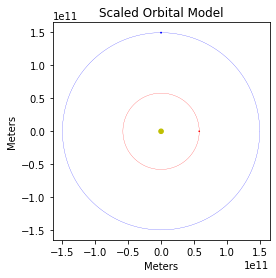

In [3]:
def DrawCircle(radius, linecolor):
    x = []
    y = []
    for i in np.arange(0, 2*np.pi, .0001):
        x.append(radius*np.cos(i))
        y.append(radius*np.sin(i))
    plt.plot(x,y, linecolor, linewidth = .2)
sun = plt.Circle((0,0), SolarSystemParameters["SunRadius"]*5, color = 'y')
earth = plt.Circle((0, SolarSystemParameters["EarthOrbitRadius"]), SolarSystemParameters["EarthRadius"]*100, color = 'b')
mercury = plt.Circle((SolarSystemParameters["MercuryOrbitRadius"], 0), SolarSystemParameters["MercuryRadius"]*200, color = 'r')
fig, solarsystem = plt.subplots()
solarsystem.add_patch(sun)
solarsystem.add_patch(earth)
solarsystem.add_patch(mercury)
solarsystem.plot()
DrawCircle(SolarSystemParameters["EarthOrbitRadius"], 'b')
DrawCircle(SolarSystemParameters["MercuryOrbitRadius"], 'r')
plt.axis('scaled')
plt.title("Scaled Orbital Model")
plt.ylabel('Meters')
plt.xlabel('Meters')
plt.show()

## Orbital Dynamics 

In [4]:
resetMe(['SolarSystemParameters', 'params'])
def F(position, SolarSystemParameters, params):
    x = position[0]
    y = position[1]
    m = params["orbitingBodyMass"]
    M = params["centralBodyMass"]
    G = SolarSystemParameters["G"]
    ax = (-1 * G*M * x) / ( (x**2 + y**2)**(3/2))
    ay = (-1 * G*M * y) / ( (x**2 + y**2)**(3/2))
    force = np.array([m*ax, m*ay])
    return force

def Step(time, position, velocity, SolarSystemParameters, params):
    m = params["orbitingBodyMass"]
    dt = params["dt"]
    a = F(position, SolarSystemParameters, params) / m
    positionMidPoint = position + velocity * dt/2
    velocityMidPoint = velocity + a*dt/2
    aMidPoint = F(positionMidPoint, SolarSystemParameters, params) / m
    deltaPosition = velocityMidPoint * dt
    deltaVelocity = aMidPoint * dt
    new_time = time + dt
    new_position = position + deltaPosition
    new_velocity = velocity + deltaVelocity
    return (new_time,new_position,new_velocity)

def Orbit(SolarSystemParameters, params):
    initialPosition = params["initialPosition"]
    positions = []
    positions.append(initialPosition)
    initialVelocity = params["initialVelocity"]
    velocities = []
    velocities.append(initialVelocity)
    initialTime = params["initialTime"]
    times = []
    times.append(initialTime)
    dt = params["dt"]
    runTime = params["T"]
    crashRadius = params["crashRadius"]
    for i in range(0, int(runTime/dt), 1):
          new_time, new_position, new_velocity = Step(times[i], positions[i], velocities[i], SolarSystemParameters, params)
          newRadius = (new_position[0]**2 + new_position[1]**2)**.5
          if (newRadius < crashRadius):
            break
          positions.append(new_position)
          times.append(new_time)
          velocities.append(new_velocity)
    
    return np.array(times),np.array(positions),np.array(velocities)
    


### Earth Orbiting the Sun

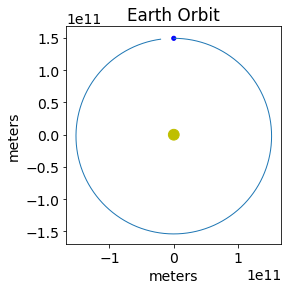

In [5]:
resetMe(['SolarSystemParameters','Orbit','Step','F'])
params = dict()
params["orbitingBodyMass"] = SolarSystemParameters['EarthMass']
params["centralBodyMass"] = SolarSystemParameters["SunMass"]
params["dt"] = 3600
params["crashRadius"] = 1000
params["initialPosition"] = np.array([0, SolarSystemParameters['EarthOrbitRadius']])
params["initialVelocity"] = np.array([SolarSystemParameters['EarthOrbitVelocity'], 0])
params["T"] = 60*60*24*365.25
params["initialTime"] = 0
time, position, velocity = Orbit(SolarSystemParameters, params)
sun = plt.Circle((0,0), SolarSystemParameters["SunRadius"]*12, color = 'y')
earth = plt.Circle((0, SolarSystemParameters["EarthOrbitRadius"]), SolarSystemParameters["EarthRadius"]*500, color = 'b')
fig, solarsystem = plt.subplots()
solarsystem.add_patch(sun)
solarsystem.add_patch(earth)
solarsystem.plot()
plt.plot(position[:,0], position[:,1], linewidth = 1)
plt.axis('scaled')
plt.title('Earth Orbit')
plt.xlabel("meters")
plt.ylabel("meters")

plt.show()


### Geosyncronous Orbit. 

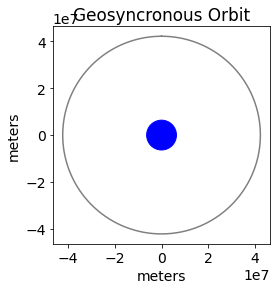

In [6]:
resetMe(['SolarSystemParameters','Orbit','Step','F', 'params'])
params["dt"] = 1
params["orbitingBodyMass"] = 100
params["centralBodyMass"] = SolarSystemParameters["EarthMass"]
params["T"] = 60*60*24
radius = (SolarSystemParameters['G']*SolarSystemParameters['EarthMass']*params['T']**2/(4*np.pi**2))**(1/3)
velocity = (SolarSystemParameters['G']*SolarSystemParameters['EarthMass'] / radius)**.5
params["initialVelocity"] = np.array([velocity, 0])
params["initialPosition"] = np.array([0, radius])
params["initialTime"] = 0
params["crashRadius"] = 1000

times, positions, velocities = Orbit(SolarSystemParameters, params)

earth = plt.Circle((0, 0), SolarSystemParameters["EarthRadius"], color = 'b')
fig, solarsystem = plt.subplots()
solarsystem.add_patch(earth)
solarsystem.plot()

plt.plot(positions[:,0], positions[:,1], color = 'gray')

plt.axis('scaled')
plt.title('Geosyncronous Orbit')
plt.ylabel('meters')
plt.xlabel('meters')
plt.show()

### Animation

In [7]:
from matplotlib import animation
from IPython.display import HTML

def animateMe(positions,fullLine=True):
    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure();
    x_min=np.min(positions[:,0])*1.1
    x_max=np.max(positions[:,0])*1.1
    y_min=np.min(positions[:,1])*1.1
    y_max=np.max(positions[:,1])*1.1
    ax = plt.axes(xlim=(x_min, x_max), ylim=(y_min, y_max));
    #plt.axis('scaled')
    
    #line, = ax.plot([], [], lw=2);
    plt.plot([0],[0],'ro',markersize=10)
    line, = ax.plot([], [],'bo', ms=10);
    plt.close(fig)
    # initialization function: plot the background of each frame
    def init():
        line.set_data([], [])
        return line,

    # animation function.  This is called sequentially
    def animate(i):

        x = positions[:,0]
        y = positions[:,1]
        if fullLine:
            line.set_data(positions[0:i,0], positions[0:i,1])
        else:
            line.set_data(positions[i,0],positions[i,1])

#        line.set_markersize(10)
        return line,

    # call the animator.  blit=True means only re-draw the parts that have changed.

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(positions), interval=20, 
                                   blit=True,repeat=False);
    return anim

stepSize=len(positions)//100
anim=animateMe(positions[::stepSize,:],True)
HTML(anim.to_jshtml())

## Kepler's Laws

(1) The orbit of a planet is an ellipse with the Sun at one of the two foci.

(2) A line segment joining a planet and the Sun sweeps out equal areas during equal intervals of time.

(3) The square of the orbital period of a planet is directly proportional to the cube of the semi-major axis of its orbit.

### Law 1

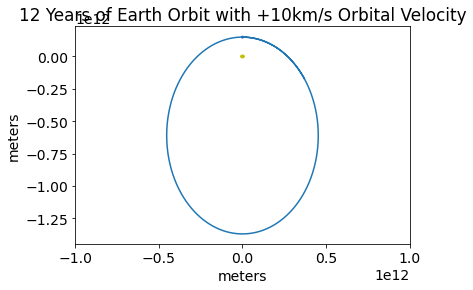

4.387427371977118e+35
Is ellipse: True


In [8]:
resetMe(['Orbit','Step','F','SolarSystemParameters','params'])
params["centralBodyMass"] = SolarSystemParameters['SunMass']
params["dt"] = 3600
params["crashRadius"] = 1000
params["orbitingBodyMass"] = SolarSystemParameters['EarthMass']
params["T"] = 60*60*24*365*12
params["initialTime"] = 0
params["initialPosition"] = np.array([0, SolarSystemParameters['EarthOrbitRadius']])
params["initialVelocity"] = np.array([SolarSystemParameters['EarthOrbitVelocity'] + 10000, 0])
def CheckEllipse(x,y):
    isEllipse = True
    pMin = np.array([0,0])
    pMax = np.array([0,0])
    rMin = 999999999999999
    rMax = 0
    for i in range(0, len(x) - 1, 1):
      if ((x[i] **2 + y[i]**2)**.5 > rMax):
        rMax = (x[i] **2 + y[i]**2)**.5
        pMax = np.array([x[i], y[i]])
    for j in range(0, len(x) - 1, 1):
      if ((x[j] **2 + y[j]**2)**.5 < rMin):
        rMin = (x[j] **2 + y[j]**2)**.5
        pMin = np.array([x[j], y[j]])
    aMagnitude = (rMin + rMax)/2
    bMagnitude = (rMin * rMax)**.5
    center = (pMin + pMax)/2
    aVector = (pMax - pMin)
    A = np.arctan(aVector[1]/aVector[0])
    for k in range(0, len(x) - 1, 1):
      firstTerm = ( ((x[k] - center[0])*np.cos(A) + (y[k] - center[1]) * np.sin(A))**2) / aMagnitude**2
      secondTerm = ( ((x[k] - center[0])*np.sin(A) - (y[k] - center[1]) * np.cos(A))**2) / bMagnitude**2
      if not (.9999 < firstTerm + secondTerm < 1.0001): #wiggle room for dt error
        print(firstTerm + secondTerm)
        isEllipse = False
        break
    print(aMagnitude**3)
    return isEllipse

timess,positions,velocities=Orbit(SolarSystemParameters, params)
sun = plt.Circle((0,0), SolarSystemParameters["SunRadius"]*16, color = 'y')
earth = plt.Circle((0, SolarSystemParameters["EarthOrbitRadius"]), SolarSystemParameters["EarthRadius"]*1030, color = 'b')
fig, solarsystem = plt.subplots()
solarsystem.add_patch(sun)
solarsystem.add_patch(earth)
solarsystem.plot()
plt.plot(positions[:,0], positions[:,1])
plt.xlim(-1e12, 1e12)
plt.title('12 Years of Earth Orbit with +10km/s Orbital Velocity')
plt.xlabel('meters')
plt.ylabel('meters')
plt.show()

print('Is ellipse:', CheckEllipse(positions[:,0],positions[:,1]))

### Law 2

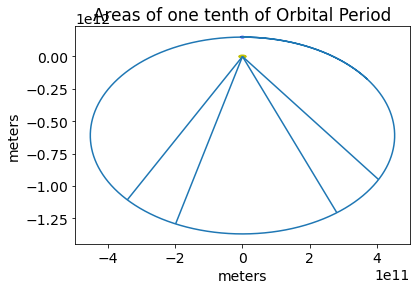

The two areas are: 1.1320529749212e+23 & 1.1320529748477677e+23 meters squared
1.0000000000648666


In [9]:
resetMe(['SolarSystemParameters','Orbit','Step','F', 'params'])
from matplotlib import collections as collection
times,positions,velocities=Orbit(SolarSystemParameters, params)
dt = params["dt"]
T = params["T"]
firstPortion = positions[int(.2*T/dt):int(.3*T/dt)]
secondPortion = positions[int(.6*T/dt):int(.7*T/dt)+1]
indexLength = int(.1*T/dt)
def TriangleArea(A, B, C):
  temp = (A[0] * (B[1] - C[1]) + B[0] * (C[1] - A[1]) + C[0] * (A[1] - B[1])) / 2
  area = np.abs(temp)
  return area
totalAreaFirst = 0
totalAreaSecond = 0
for i in range(0, indexLength - 2, 1):
  totalAreaFirst += TriangleArea(np.array([0,0]), firstPortion[i], firstPortion[i+1])
  totalAreaSecond += TriangleArea(np.array([0,0]), secondPortion[i], secondPortion[i+1])

lines = [[(0,0), (firstPortion[0][0], firstPortion[0][1])], [(0,0), (firstPortion[indexLength -1][0], firstPortion[indexLength - 1][1])], [(0,0), (secondPortion[0][0], secondPortion[0][1])], [(0,0), (secondPortion[indexLength -1][0], secondPortion[indexLength - 1][1])]]
l = collection.LineCollection(lines)
fig, ax = plt.subplots()
sun = plt.Circle((0,0), SolarSystemParameters["SunRadius"]*16, color = 'y')
earth = plt.Circle((0, SolarSystemParameters["EarthOrbitRadius"]), SolarSystemParameters["EarthRadius"]*1030, color = 'b')
ax.add_patch(sun)
ax.add_patch(earth)
ax.add_collection(l)
plt.plot(positions[:,0], positions[:,1])
plt.title("Areas of one tenth of Orbital Period")
plt.xlabel("meters")
plt.ylabel("meters")
plt.show()
print("The two areas are:", totalAreaFirst, "&", totalAreaSecond, "meters squared")
print(totalAreaFirst/totalAreaSecond)


### Law 3

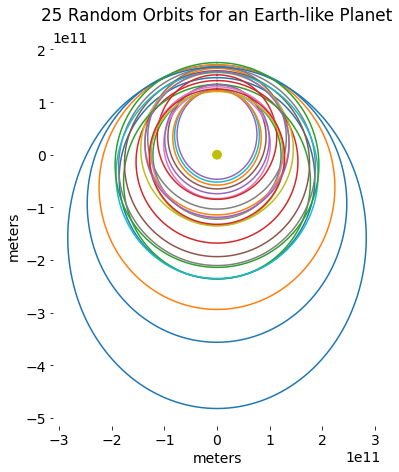

In [10]:
def Orbit(SolarSystemParameters, params):
    initialPosition = params["initialPosition"]
    positions = []
    positions.append(initialPosition)
    initialVelocity = params["initialVelocity"]
    velocities = []
    velocities.append(initialVelocity)
    initialTime = params["initialTime"]
    times = []
    times.append(initialTime)
    dt = params["dt"]
    runTime = params["T"]
    crashRadius = params["crashRadius"]
    for i in range(0, int(runTime/dt), 1):
          new_time, new_position, new_velocity = Step(times[i], positions[i], velocities[i], SolarSystemParameters, params)
          newRadius = (new_position[0]**2 + new_position[1]**2)**.5
          if (newRadius < crashRadius):
            break
          if (i >= 2):
            if (positions[i - 1][0] <= initialPosition[0] and positions[i][0] >= initialPosition[0]):
              break
          positions.append(new_position)
          times.append(new_time)
          velocities.append(new_velocity)
    return np.array(times),np.array(positions),np.array(velocities)
params["dt"] = 60
params["centralBodyMass"] = SolarSystemParameters['SunMass']
params["crashRadius"] = 1000
params["orbitingBodyMass"] = SolarSystemParameters['EarthMass']
params["T"] = 60*60*24*365*20
params["initialTime"] = 0
params["initialPosition"] = np.array([0, SolarSystemParameters['EarthOrbitRadius']])
v_circ = np.sqrt(SolarSystemParameters["G"]*SolarSystemParameters["SunMass"]/SolarSystemParameters['EarthOrbitRadius'])
semiMajorAxisCubed = []
orbitalPeriodSquared = []
for i in range(0,25,1):
  v0=[(v_circ+np.random.uniform(-0.2,0.2)*v_circ), 0]
  params["initialVelocity"] = np.array(v0)
  params["initialPosition"] = np.array([0, SolarSystemParameters['EarthOrbitRadius'] + np.random.uniform(-.2,.2)*SolarSystemParameters['EarthOrbitRadius']])
  times, positions, velocities = Orbit(SolarSystemParameters, params)
  plt.plot(positions[:,0], positions[:,1])
  rMin = 999999999999999
  rMax = 0
  finalIndex = (len(positions) - 1) * params["dt"]
  for i in range(0, len(positions) - 1, 1):
    if ((positions[i][0] **2 + positions[i][1]**2)**.5 > rMax):
      rMax = (positions[i][0] **2 + positions[i][1]**2)**.5
    if ((positions[i][0] **2 + positions[i][1]**2)**.5 < rMin):
      rMin = (positions[i][0] **2 + positions[i][1]**2)**.5
  aMagnitude = ((rMin + rMax)/2)
  semiMajorAxisCubed.append(aMagnitude**3)
  orbitalPeriodSquared.append(finalIndex**2)

plt.title('25 Random Orbits for an Earth-like Planet', pad = 25)
plt.xlabel('meters')
plt.ylabel('meters')
orbits = plt.gca()
orbits.set_frame_on(False)
sun = plt.Circle((0,0), SolarSystemParameters["SunRadius"]*12, color = 'y')
orbits.add_patch(sun)

plt.axis('image')
orbit = plt.gcf()
orbit.set_size_inches(7, 7)
plt.show()

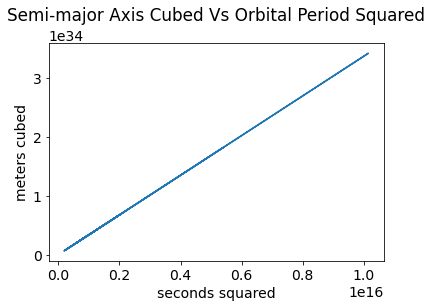

The slope of this line is 3.3625297359727114e+18 which is 99.99992611820515 percent of the expected value of 3.362532220271868e+18


In [11]:

plt.plot(orbitalPeriodSquared, semiMajorAxisCubed)
myLine = np.polyfit(np.array(orbitalPeriodSquared, dtype = np.float), np.array(semiMajorAxisCubed, dtype = np.float), 1)
expectedValue = (SolarSystemParameters["G"]*SolarSystemParameters['SunMass']) / (4 * np.pi**2)
myValue = myLine[0]
plt.title("Semi-major Axis Cubed Vs Orbital Period Squared", pad = 23)
plt.xlabel("seconds squared")
plt.ylabel("meters cubed")
plt.show()
print('The slope of this line is', myLine[0], 'which is', 100*myValue/expectedValue, "percent of the expected value of", expectedValue)

## Forces using automatic differentiation

In [12]:
resetMe(['SolarSystemParameters','params', 'Orbit', 'Step'])
def E(position, SolarSystemParameters, params):
    G = SolarSystemParameters["G"]
    M = params["centralBodyMass"]
    m = params["orbitingBodyMass"]
    E = (G*M*m)/ jnp.sqrt(position[0]**2 + position[1]**2)
    return E


/Users/gavin/opt/anaconda3/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


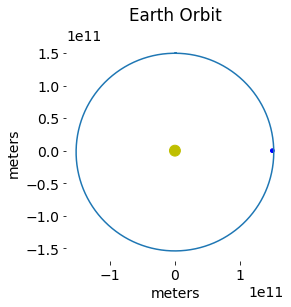

In [13]:
def F(position, SolarSystemParameters, params):
    return grad(E,0)(position, SolarSystemParameters, params)


params["dt"] = 60*60*24
params["T"] = 60*60*24*365.25*2
params["initialVelocity"] = np.array([SolarSystemParameters["EarthOrbitVelocity"], 0])
params["initialPosition"] = np.array([0, SolarSystemParameters["EarthOrbitRadius"]])
params["orbitingBodyMass"] = SolarSystemParameters["EarthMass"]
params["centralBodyMass"] = SolarSystemParameters["SunMass"]
times, positions, velocities = Orbit(SolarSystemParameters, params)
plt.plot(positions[:,0], positions[:,1])
sun = plt.Circle((0,0), SolarSystemParameters["SunRadius"]*12, color = 'y')
earth = plt.Circle((SolarSystemParameters['EarthOrbitRadius'], 0), SolarSystemParameters['EarthRadius']*450, color = 'b')
x = plt.gca()
x.add_patch(sun)
x.add_patch(earth)
plt.axis('image')
x.set_frame_on(False)
plt.title('Earth Orbit', pad = 23)
plt.xlabel('meters')
plt.ylabel('meters')
plt.show()